<a href="https://colab.research.google.com/github/Suvranil97/Starting-with-Jupyter/blob/master/biased_random_walk_in_a_regular_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Program background
* This is property of the half blood prince.
* **Target:** Here we want to find out the relation between cover time and first passage time for biased random walk in an arbitrary complex network. We apreical exlready know the results for unbiased network. Now we want to do first simulate cover time in a complex network (for biased random walk). Then we will inspect if there is any analytical way to express cover time by first passage time.
* **Source:** <br>
    * [Bonaventura, M., Nicosia, V., & Latora, V. (2014). Characteristic times of biased random walks on complex networks. Physical Review E - Statistical, Nonlinear, and Soft Matter Physics, 89(1), 1–15.](https://doi.org/10.1103/PhysRevE.89.012803)
    * [Maier, B. F., & Brockmann, D. (2017). Cover time for random walks on arbitrary complex networks.Physical Review E, 96(4), 1–9.](https://doi.org/10.1103/PhysRevE.96.042307)
    * [Masuda, N., Porter, M. A., & Lambiotte, R. (2017). Random walks and diffusion on networks. Physics Reports, 716–717, 1–58.](https://doi.org/10.1016/j.physrep.2017.07.007)

* **Comment**: This work is in progress. So neither sources nor all comments in program and background stories are completed. We will keep it updated with time.



In [ ]:
#call important library
import numpy as np
import networkx as nx
import scipy
import matplotlib.pyplot as plt
import bisect
from joblib import Parallel, delayed

In [ ]:
def graph1(d,N):  #N= number of total node and p= probability
    return nx.random_regular_graph(d,N)   #random regular graph
    

In [ ]:
def transition_matrix(graph,alpha):                # making transition matrix for biased random walk
    N=nx.number_of_nodes(graph)                    #total number of nodes in the graph
    pi=np.zeros((N,N))                             # data structure for transition matrix
    A=nx.adjacency_matrix(graph)                   # adjacency matrix of the graph
    for i in range (0,N,1):
        total=0
        for l in range(0,N,1):
            total=A[i,l]*(graph.degree(l))**alpha+total          #summation from denominator of equation (1)
        for j in range (0,N,1):
            pi[j][i]=(A[i,j]*(graph.degree(j))**alpha)/total     #implementation of equation (1)
        
    return pi


Here we will try to find out the fundamental matrix. Formula of fundamental matrix: <br>
$\begin{equation}z=(\mathbb{1}-\pi^T +w)^{-1}\tag{1}\end{equation}$ <br>where z is fundamental matrix, $\mathbb{1}$ is identity matrix of order N(total number of nodes, $\pi$ is transition matrix and each row of $w$ is equal to the stationary probability distribution.  [Ref :Equation 15 of this paper](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.85.056120)<br>
**Note**: *Stationary probability distribution:* <br>
$\pi p^*=p^*\tag {2}$ where $p^*$ is stationary probability distribution. So to finding stationary probability, we have to find out eigenvector of $\pi$ corresponding to eigenvalue 1. By the way, it's the largest eigenvalue of transition matrix. [Ref:Check the paragraph after equation (45) of this review article](http://dx.doi.org/10.1016/j.physrep.2017.07.007)


In [ ]:
#Finding stationary_probability distribution
def stationary_probability(matrix):       #here matrix equivalent to pi(aka transition matrix)
    evals, evecs = scipy.sparse.linalg.eigs(matrix, k=1, which='LM')
    total=np.sum(abs(evecs))  #normalization of probability
    stationary_probability_matrix=abs(evecs)/total #to making summation of all probility 1
    return stationary_probability_matrix
#comment: with this scipy function, we can find out maximum (N-1) eigenvector of an N order matrix.Here k 
#(contd.) stands for number of desired eigenvector and 'LM' stands for largest magnitude.     

In [ ]:
def fundamental_matrix(N,pi,stationary_probability_matrix):
    w=np.zeros((N,N))     # each row of w is equal to the stationary probability distribution
    identity = np.identity(N)                #identity matrix of order N
    pi_transpose=np.transpose(pi)            # transpose of transition matrix
    for i in range (0,N,1):
        for j in range (0,N,1):
            w[i][j]=stationary_probability_matrix[j]     #stationary probability matrix is p* in equation (2)  
    fundamental=np.linalg.inv(identity-pi_transpose+w)            #fundamental  matrix from equation (1)
    return fundamental

Using fundamental matrix, we can easily find out the MFPT (mean first passage time) matrix. We know,<br>
$\begin{align}
t_{ij}=\frac{z_{jj}-z_{ij}}{p_{j}^*}
\end{align}
$


In [ ]:
def mfpt_matrix(N,stationary_probability_matrix,fundamental_matrix):
    mfpt=np.zeros((N,N))                #data structure for mfpt matrix
    for i in range (0,N,1):
        for j in range (0,N,1):
            mfpt[i][j]=(fundamental_matrix[j][j]-fundamental_matrix[i][j])/stationary_probability_matrix[j]  #implementation of eq(3)
    return mfpt

In [ ]:
def probability_matrix(N,pi):
    probability_matrix=np.zeros((N,N))     #data structure for an matrix which row is fibonacci series
    probability=100*(np.transpose(pi))     #mutiplying wth 100 to use randint
    for i in range (0,N,1):                
        for j in range (0,N,1):
            if j!=0:
                probability_matrix[i][j]= probability_matrix[i][j-1]+probability[i,j]   #fibonacci series
            else:
                probability_matrix[i][j]=probability[i,j]             # for first element in a row
    return probability_matrix

In [ ]:
def gmct2(source1,random_walker,max_walk_time,probability_matrix):
    coverage_time=np.zeros(random_walker)                 #data structure to contain coverage time of every walker
    for walker in range (0,random_walker,1):              # various random walkers
        cover_time=[]   #data structure containing path of walker
        for j in range (0,max_walk_time,1):     #this max_walk_time should be depend on computation power and number
            cover_time=np.append(cover_time,source1)#(cont.) number of node of system
            if len(np.unique(cover_time))==N:   #game over when every node is touched
                total=len(cover_time)
                break
            else:
                array=probability_matrix[source1]      #select corresponding row of probability matrix
                number=np.random.randint(1,101)
                source1=bisect.bisect_left(array,number, lo=0, hi=len(a)-1)
        coverage_time[walker]=total
    #mean_coverage_time_matrix[source1]=np.sum(coverage_time)/random_walker
    return (np.sum(coverage_time)/ random_walker) 

In [ ]:
def gmct2(source1,random_walker,max_walk_time,probability_matrix,N,transition_matrix):
    coverage_time=np.zeros(random_walker)                 #data structure to contain coverage time of every walker
    for walker in range (0,random_walker,1):              # various random walkers
        cover_time=[]   #data structure containing path of walker
        for j in range (0,max_walk_time,1):     #this max_walk_time should be depend on computation power and number
            cover_time=np.append(cover_time,source1)#(cont.) number of node of system
            if len(np.unique(cover_time))==N:   #game over when every node is touched
                total=len(cover_time)
                break
            else:
                array=probability_matrix[source1]      #select corresponding row of probability matrix
                number=np.random.randint(1,101)
                source1=bisect.bisect_left(array,number, lo=0, hi=len(transition_matrix)-1)
        coverage_time[walker]=total
    #mean_coverage_time_matrix[source1]=np.sum(coverage_time)/random_walker
    return (np.sum(coverage_time)/ random_walker) 

CPU times: user 17 s, sys: 1.37 s, total: 18.4 s
Wall time: 5min 27s


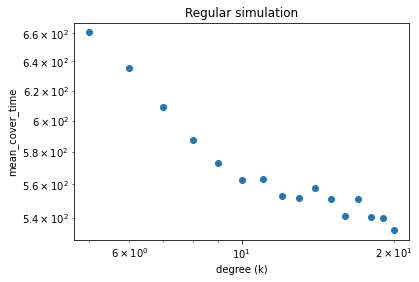

In [ ]:
%%time
N=100
alpha=0.0
random_walker=10
max_walk_time=10**6
highest_number_of_node=21
lowest_number_of_node=5
global_mean_coverage_time=np.zeros(highest_number_of_node-lowest_number_of_node)  
degree=np.zeros(highest_number_of_node-lowest_number_of_node)
for d in range (lowest_number_of_node,highest_number_of_node,1):
    g=graph1(d,N)
    a=transition_matrix(g,alpha)
    b=stationary_probability(a)
    c=fundamental_matrix(N,a,b)
    e=mfpt_matrix(N,b,c)
    f=probability_matrix(N,a)
    mean_coverage_time_matrix=np.zeros(N)
    mean_coverage_time=Parallel(n_jobs=4,verbose=0)(delayed(gmct2)(i,random_walker,max_walk_time,f,N,a) for i in range (0,N))
    global_mean_coverage_time[d-lowest_number_of_node]=np.sum(mean_coverage_time)/N
    degree[d-lowest_number_of_node]=(d)

#Plot details
plt.scatter(degree,global_mean_coverage_time)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('degree (k)')
plt.ylabel('mean_cover_time')
plt.title('Regular simulation')
#print(a)